**[TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/overview#all_datasets) is a collection of open source datasets that you can use in ML.**

In [1]:
# import libraries 
import tensorflow as tf
!pip install tensorflow_datasets
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


**Downloading the flowers dataset from tensorflow datasets and split into training set 70% testing/validation 30%. Dataset_info contaains more detailed information about the dataset**

****

In [2]:

(training_set, validation_set), dataset_info = tfds.load(
    'tf_flowers',
    split=['train[:70%]', 'train[70%:]'],
    with_info=True,
    as_supervised=True,
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


**Image classification tasks are usually heavy on computation resources so we need to use GPU to make the training faster. GPU training is 3X faster or more comapred to CPU...this code cell checks the gpu status in terms of specs**

In [3]:
!nvidia-smi

Thu Jul 15 14:47:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P0    30W /  70W |    222MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**Explore the dataset see how many images classes (flowers) are in the dataset and number of images in the training and validation/testing set**

In [18]:
num_classes = dataset_info.features['label'].num_classes
num_classes

num_training_examples = 0
num_validation_examples = 0
for example in training_set:
    num_training_examples += 1
for example in validation_set:
    num_validation_examples += 1
print('Total Number of Classes: {}'.format(num_classes))
print('Total Number of Training Images: {}'.format(num_training_examples))
print('Total Number of Validation Images: {} \n'.format(num_validation_examples))

Total Number of Classes: 5
Total Number of Training Images: 2569
Total Number of Validation Images: 1101 



**Images sizes need to be uniform in a dataset, explore the dataset and see if the images are of the same size**

In [6]:
# loop through the training set and take 5 images, check the image size
for i, example in enumerate(training_set.take(5)):
    print('Image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]))

Image 1 shape: (333, 500, 3) label: 2
Image 2 shape: (212, 320, 3) label: 3
Image 3 shape: (240, 320, 3) label: 3
Image 4 shape: (240, 320, 3) label: 4
Image 5 shape: (317, 500, 3) label: 3


In [7]:
# class names for the 5 flowers in the dataset----> [0]-Dandelion....[4]-roses
class_names = np.array(dataset_info.features['label'].names)
print(class_names)

['dandelion' 'daisy' 'tulips' 'sunflowers' 'roses']


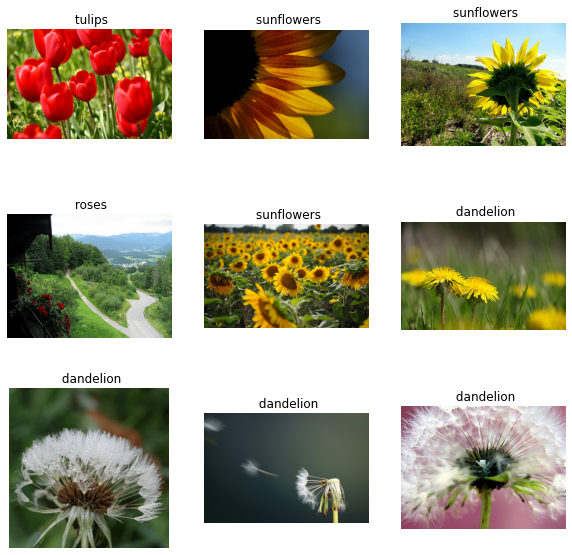

In [9]:
# visualize 9 images from the training set
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(training_set.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    name = class_names[label]  
    plt.imshow(image)
    plt.title(' {}'.format(name))
    plt.axis("off")

**Inception v3 model was trained on image size of 299,299,3 images so all our images need to be in this same resolution.**

**batches are portions of our training data that we feed into our model At the end of the batch, the predictions are compared to the expected output variables and an error is calculated. From this error, the update algorithm is used to improve the model, typical values are 32,64,128**

In [10]:
IMAGE_RES = 299

def format_image(image, label):
    image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
    return image, label
BATCH_SIZE = 32
train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)
print(train_batches)
print(validation_batches)

<PrefetchDataset shapes: ((None, 299, 299, 3), (None,)), types: (tf.float32, tf.int64)>
<PrefetchDataset shapes: ((None, 299, 299, 3), (None,)), types: (tf.float32, tf.int64)>


[Tensorflow hub](https://tfhub.dev/s?module-type=image-feature-vector&tf-version=tf2)  is an online repo for popular  ML models

In [17]:
!pip install tensorflow_hub
import tensorflow_hub as hub
URL = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES, 3))

In [ ]:
feature_extractor.trainable = False

In [ ]:
model = tf.keras.Sequential([
  feature_extractor,
  tf.keras.layers.Dense(num_classes)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 10,245
Non-trainable params: 21,802,784
_________________________________________________________________


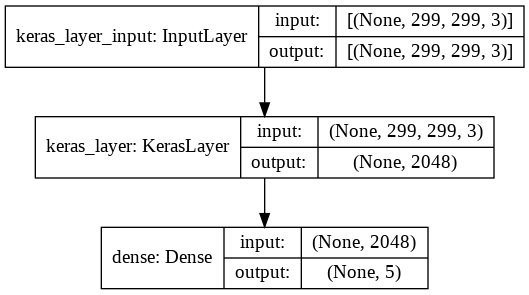

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png') 

In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
EPOCHS = 10
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/10
81/81 [==============================] - 72s 447ms/step - loss: 0.7515 - accuracy: 0.7299 - val_loss: 0.4563 - val_accuracy: 0.8556
Epoch 2/10
81/81 [==============================] - 32s 395ms/step - loss: 0.4004 - accuracy: 0.8696 - val_loss: 0.3586 - val_accuracy: 0.8810
Epoch 3/10
81/81 [==============================] - 32s 395ms/step - loss: 0.3119 - accuracy: 0.9000 - val_loss: 0.3170 - val_accuracy: 0.8937
Epoch 4/10
81/81 [==============================] - 32s 394ms/step - loss: 0.2601 - accuracy: 0.9253 - val_loss: 0.3008 - val_accuracy: 0.9001
Epoch 5/10
81/81 [==============================] - 32s 396ms/step - loss: 0.2327 - accuracy: 0.9292 - val_loss: 0.3041 - val_accuracy: 0.8946
Epoch 6/10
81/81 [==============================] - 32s 396ms/step - loss: 0.2060 - accuracy: 0.9408 - val_loss: 0.2839 - val_accuracy: 0.9028
Epoch 7/10
81/81 [==============================] - 32s 396ms/step - loss: 0.1803 - accuracy: 0.9521 - val_loss: 0.2840 - val_accuracy: 0.8965

Text(0.5, 1.0, 'Training and Validation Loss')

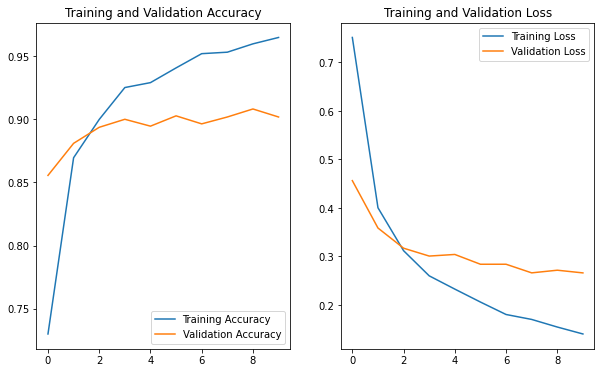

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(EPOCHS)
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

In [ ]:
class_names = np.array(dataset_info.features['label'].names)
print(class_names)

['dandelion' 'daisy' 'tulips' 'sunflowers' 'roses']


In [ ]:
image_batch, label_batch = next(iter(validation_batches))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
print(predicted_class_names)

['roses' 'dandelion' 'daisy' 'daisy' 'dandelion' 'sunflowers' 'dandelion'
 'sunflowers' 'daisy' 'sunflowers' 'dandelion' 'daisy' 'daisy' 'tulips'
 'roses' 'sunflowers' 'roses' 'tulips' 'tulips' 'tulips' 'dandelion'
 'daisy' 'tulips' 'tulips' 'sunflowers' 'dandelion' 'sunflowers'
 'sunflowers' 'sunflowers' 'daisy' 'dandelion' 'tulips']


In [ ]:
print("Labels:           ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:            [4 0 1 3 0 3 0 3 1 3 0 1 1 2 4 3 4 2 2 0 0 1 2 2 3 3 3 3 3 1 0 4]
Predicted labels:  [4 0 1 1 0 3 0 3 1 3 0 1 1 2 4 3 4 2 2 2 0 1 2 2 3 0 3 3 3 1 0 2]


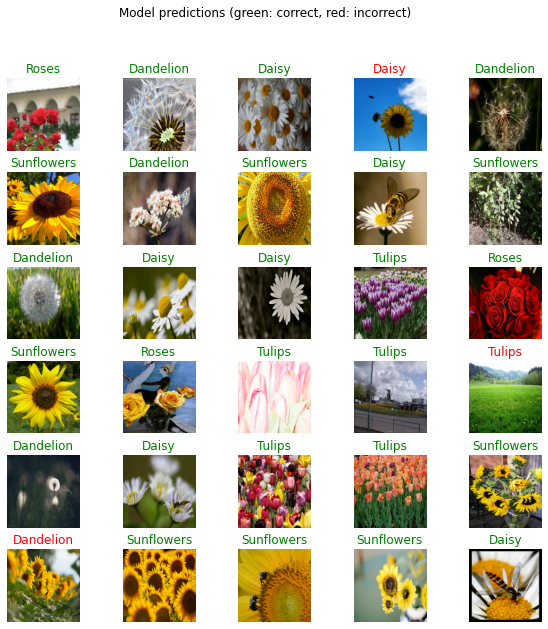

In [ ]:
plt.figure(figsize=(10,10))
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.subplots_adjust(hspace = 0.3)
    plt.imshow(image_batch[n])
    color = "green" if predicted_ids[n] == label_batch[n] else "red"
    plt.title(predicted_class_names[n].title(), color=color)
    plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

In [1]:
from keras.applications.vgg16 import VGG16


vgg = VGG16(input_shape=(224,224,3),weights='imagenet',include_top=False)
# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False

58900480/58889256 [==============================] - 0s 0us/step


In [2]:
from keras.layers import Lambda,Dense,Flatten
from keras.models import Model

x = Flatten()(vgg.output)
prediction = Dense(5, activation='sigmoid')(x)

# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()

# tell the model what cost and optimization method to use
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     